In [1]:
# user parameters
key = open('../api-key/omdb.txt', 'r').read()
searchlist = ['love', 'ball', 'war', 'book', 'game', 'future', 'earth', 'princess']

In [2]:
import pandas as pd
import requests
import json

# helper functions
def getratings(ratinglist):
    """ 
     TODO: comment this helper function
       """
    returnlist = []
    for rating in ratinglist:
        dict_r = dict(rating)
        return_r = [dict_r['Source'], dict_r['Value']]
        returnlist.append(return_r)
    return returnlist

def load_data(key, searchlist):
    """ 
    load_data extracts movie data from OMDB API, based on a list of words provided in searchlist
    :param key: apikey to access the api
    :param searchlist: list of stings to search for in movie titles
    :return:  for each word in searchlist, 10 movies with the word in its title and corresponding omdb data
    """
    # initialize empty dataframe
    moviedf = pd.DataFrame()
    # retrieve the data from api and get 10 results based on keyword 
    for word in searchlist: 
        response_title = requests.get('http://www.omdbapi.com/?apikey={}&s={}&type=movie'.format(key, word))
        title_txt = response_title.text
        parse_title = json.loads(title_txt)
        if 'Search' in parse_title:
            titledf = parse_title['Search']
            titledf = pd.DataFrame.from_dict(titledf)
            titles = titledf['Title']
            # for each movietitle, acquire extra data
            for title in titles:
                response_data = requests.get('http://www.omdbapi.com/?apikey={}&t={}&plot=short'.format(key, title))
                data_txt = response_data.text
                parse_data = pd.read_json(data_txt)

                # convert multiple rows per movie into 1 row per movie by groupby and applying a function to 'Ratings' column
                groupby_cols = list(parse_data.columns)
                groupby_cols.remove('Ratings')
                parse_data = (parse_data.groupby(groupby_cols)
                .agg({'Ratings': lambda x: getratings(x)},axis=1)
                .reset_index())

                parse_data['search_word'] = word
                # add data to the final dataframe
                moviedf = pd.concat([moviedf, parse_data])
    # make sure there are no duplicates
    moviedf.reset_index(drop=True, inplace=True)
    moviedf = moviedf.loc[moviedf.astype(str).drop_duplicates().index]
    moviedf.to_excel('test.xlsx')
    return moviedf

In [47]:
moviedf = load_data(key, searchlist)
moviedf.head()

KeyboardInterrupt: 

In [120]:
moviedf = pd.read_excel('test.xlsx')
moviedf.head()

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings,search_word
0,0,"Crazy, Stupid, Love.",2011,PG-13,29 Jul 2011,118 min,"Comedy, Drama, Romance","Glenn Ficarra, John Requa",Dan Fogelman,"Steve Carell, Ryan Gosling, Julianne Moore",...,"535,806",tt1570728,movie,13 Apr 2016,"$84,379,584","Carousel, DiNovi Pictures",NaN,True,"[['Internet Movie Database', '7.4/10'], ['Rott...",love
1,1,Love Actually,2003,R,14 Nov 2003,135 min,"Comedy, Drama, Romance",Richard Curtis,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson",...,"504,238",tt0314331,movie,27 Apr 2004,"$59,696,144",NaN,NaN,True,"[['Internet Movie Database', '7.6/10'], ['Rott...",love
2,2,Dr. Strangelove or: How I Learned to Stop Worr...,1964,PG,29 Jan 1964,95 min,"Comedy, War",Stanley Kubrick,"Stanley Kubrick, Terry Southern, Peter George","Peter Sellers, George C. Scott, Sterling Hayden",...,"501,965",tt0057012,movie,21 Oct 2003,"$9,440,272",NaN,NaN,True,"[['Internet Movie Database', '8.4/10'], ['Rott...",love
3,3,Thor: Love and Thunder,2022,PG-13,08 Jul 2022,118 min,"Action, Adventure, Comedy",Taika Waititi,"Taika Waititi, Jennifer Kaytin Robinson, Stan Lee","Chris Hemsworth, Natalie Portman, Christian Bale",...,"370,299",tt10648342,movie,08 Sep 2022,"$343,256,830",NaN,NaN,True,"[['Internet Movie Database', '6.2/10'], ['Rott...",love
4,4,Shakespeare in Love,1998,R,08 Jan 1999,123 min,"Comedy, Drama, History",John Madden,"Marc Norman, Tom Stoppard","Gwyneth Paltrow, Joseph Fiennes, Geoffrey Rush",...,"229,779",tt0138097,movie,07 Dec 1999,"$100,317,794",NaN,NaN,True,"[['Internet Movie Database', '7.1/10'], ['Rott...",love


In [121]:
num_cols = ['Runtime', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']
text_cols = ['Plot', 'Title']
X_cols = text_cols + num_cols
y_col = 'Genre'

In [122]:
# remove rows with NAN genre
moviedf = moviedf[moviedf['Genre'].notna()]

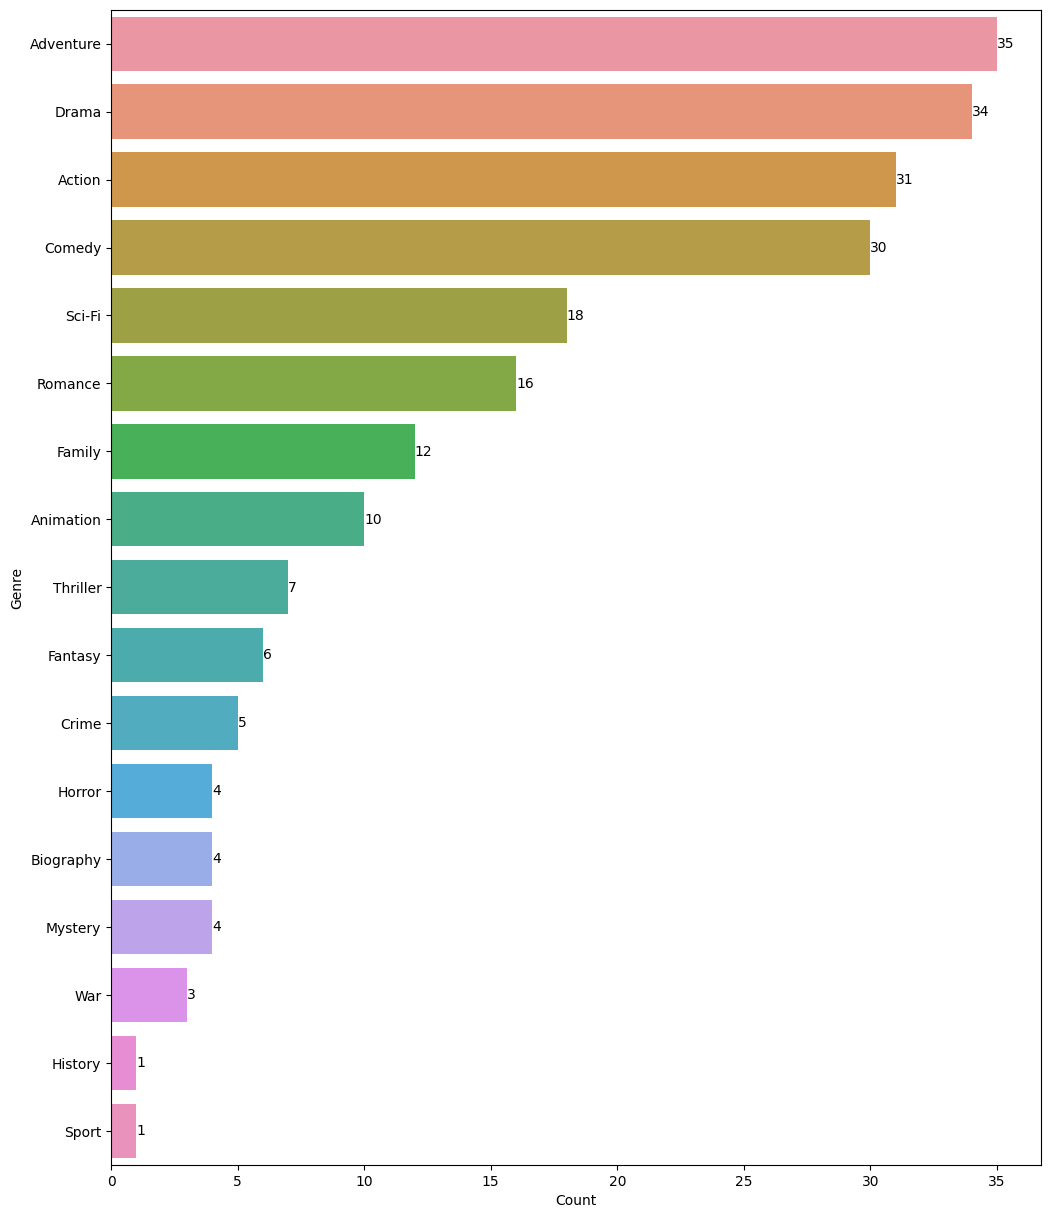

In [123]:

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

moviedf[y_col] = moviedf[y_col].apply(lambda x: x.split(', '))
genre_list = [item for sublist in moviedf['Genre'] for item in sublist]
count = Counter(genre_list)
countdf = pd.DataFrame.from_dict(count, orient='index', columns=['Count']).reset_index().sort_values(by='Count', ascending=False)
# countdf
# g = moviedf.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=countdf, x="Count", y = "index") 
for i in ax.containers:
    ax.bar_label(i,)
ax.set(ylabel = 'Genre') 
plt.show()

In [124]:
moviedf.head()

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings,search_word
0,0,"Crazy, Stupid, Love.",2011,PG-13,29 Jul 2011,118 min,"[Comedy, Drama, Romance]","Glenn Ficarra, John Requa",Dan Fogelman,"Steve Carell, Ryan Gosling, Julianne Moore",...,"535,806",tt1570728,movie,13 Apr 2016,"$84,379,584","Carousel, DiNovi Pictures",NaN,True,"[['Internet Movie Database', '7.4/10'], ['Rott...",love
1,1,Love Actually,2003,R,14 Nov 2003,135 min,"[Comedy, Drama, Romance]",Richard Curtis,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson",...,"504,238",tt0314331,movie,27 Apr 2004,"$59,696,144",NaN,NaN,True,"[['Internet Movie Database', '7.6/10'], ['Rott...",love
2,2,Dr. Strangelove or: How I Learned to Stop Worr...,1964,PG,29 Jan 1964,95 min,"[Comedy, War]",Stanley Kubrick,"Stanley Kubrick, Terry Southern, Peter George","Peter Sellers, George C. Scott, Sterling Hayden",...,"501,965",tt0057012,movie,21 Oct 2003,"$9,440,272",NaN,NaN,True,"[['Internet Movie Database', '8.4/10'], ['Rott...",love
3,3,Thor: Love and Thunder,2022,PG-13,08 Jul 2022,118 min,"[Action, Adventure, Comedy]",Taika Waititi,"Taika Waititi, Jennifer Kaytin Robinson, Stan Lee","Chris Hemsworth, Natalie Portman, Christian Bale",...,"370,299",tt10648342,movie,08 Sep 2022,"$343,256,830",NaN,NaN,True,"[['Internet Movie Database', '6.2/10'], ['Rott...",love
4,4,Shakespeare in Love,1998,R,08 Jan 1999,123 min,"[Comedy, Drama, History]",John Madden,"Marc Norman, Tom Stoppard","Gwyneth Paltrow, Joseph Fiennes, Geoffrey Rush",...,"229,779",tt0138097,movie,07 Dec 1999,"$100,317,794",NaN,NaN,True,"[['Internet Movie Database', '7.1/10'], ['Rott...",love


In [125]:
# remove classes with less than 4 instances
def remove_genre(x, genre):
    if genre in x:
        x.remove(genre)
    return x
    

less_than_4 = list(countdf.loc[countdf['Count'] < 4]['index'])
for genre in less_than_4:
    moviedf['Genre'] = moviedf['Genre'].apply(lambda x: remove_genre(x, genre))
moviedf

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings,search_word
0,0,"Crazy, Stupid, Love.",2011,PG-13,29 Jul 2011,118 min,"[Comedy, Drama, Romance]","Glenn Ficarra, John Requa",Dan Fogelman,"Steve Carell, Ryan Gosling, Julianne Moore",...,"535,806",tt1570728,movie,13 Apr 2016,"$84,379,584","Carousel, DiNovi Pictures",NaN,True,"[['Internet Movie Database', '7.4/10'], ['Rott...",love
1,1,Love Actually,2003,R,14 Nov 2003,135 min,"[Comedy, Drama, Romance]",Richard Curtis,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson",...,"504,238",tt0314331,movie,27 Apr 2004,"$59,696,144",NaN,NaN,True,"[['Internet Movie Database', '7.6/10'], ['Rott...",love
2,2,Dr. Strangelove or: How I Learned to Stop Worr...,1964,PG,29 Jan 1964,95 min,[Comedy],Stanley Kubrick,"Stanley Kubrick, Terry Southern, Peter George","Peter Sellers, George C. Scott, Sterling Hayden",...,"501,965",tt0057012,movie,21 Oct 2003,"$9,440,272",NaN,NaN,True,"[['Internet Movie Database', '8.4/10'], ['Rott...",love
3,3,Thor: Love and Thunder,2022,PG-13,08 Jul 2022,118 min,"[Action, Adventure, Comedy]",Taika Waititi,"Taika Waititi, Jennifer Kaytin Robinson, Stan Lee","Chris Hemsworth, Natalie Portman, Christian Bale",...,"370,299",tt10648342,movie,08 Sep 2022,"$343,256,830",NaN,NaN,True,"[['Internet Movie Database', '6.2/10'], ['Rott...",love
4,4,Shakespeare in Love,1998,R,08 Jan 1999,123 min,"[Comedy, Drama]",John Madden,"Marc Norman, Tom Stoppard","Gwyneth Paltrow, Joseph Fiennes, Geoffrey Rush",...,"229,779",tt0138097,movie,07 Dec 1999,"$100,317,794",NaN,NaN,True,"[['Internet Movie Database', '7.1/10'], ['Rott...",love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,75,The Tale of The Princess Kaguya,2013,PG,23 Nov 2013,137 min,"[Animation, Drama, Family]",Isao Takahata,"Isao Takahata, Riko Sakaguchi","Chloë Grace Moretz, James Caan, Mary Steenburgen",...,"50,020",tt2576852,movie,17 Feb 2015,"$974,913",NaN,NaN,True,"[['Internet Movie Database', '8.0/10'], ['Rott...",princess
74,76,My Little Princess,2010,NaN,20 Sep 2010,NaN,"[Romance, Drama, Family]",Enzo Zelocchi,Enzo Zelocchi,"Enzo Zelocchi, Charlotte Labadie, David M. Ede...",...,"43,575",tt1725047,movie,NaN,NaN,NaN,NaN,True,"[['Internet Movie Database', '3.0/10']]",princess
75,77,A Little Princess,1995,G,19 May 1995,97 min,"[Drama, Family, Fantasy]",Alfonso Cuarón,"Frances Hodgson Burnett, Richard LaGravenese, ...","Liesel Matthews, Eleanor Bron, Liam Cunningham",...,"35,753",tt0113670,movie,01 Dec 2010,"$10,015,449",NaN,NaN,True,"[['Internet Movie Database', '7.6/10'], ['Rott...",princess
76,78,The Princess Switch,2018,TV-PG,16 Nov 2018,101 min,"[Comedy, Drama, Family]",Mike Rohl,"Robin Bernheim, Megan Metzger","Vanessa Hudgens, Sam Palladio, Nick Sagar",...,"29,742",tt8954732,movie,16 Nov 2018,NaN,NaN,NaN,True,"[['Internet Movie Database', '6.1/10'], ['Rott...",princess


In [126]:
import re
import string
# data preprocessing
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

def process_num(df, num_cols):
    for col in list(num_cols):
        df.loc[:,col] = df[col].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
    return df

In [127]:
processed_df = moviedf.copy()
processed_df['Plot'] = processed_df.Plot.map(process_text)
processed_df = process_num(processed_df, num_cols)
X = processed_df[X_cols]
X.head()

,Plot,Title
0,a middle aged husband s life changes dramatica...,"Crazy, Stupid, Love."
1,follows the lives of eight very different coup...,Love Actually
2,an insane american general orders a bombing at...,Dr. Strangelove or: How I Learned to Stop Worr...
3,thor enlists the help of valkyrie korg and ex ...,Thor: Love and Thunder
4,the world s greatest ever playwright william s...,Shakespeare in Love


In [128]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(moviedf[y_col])
y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [129]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller'], dtype=object)

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62, 2) (16, 2) (62, 14) (16, 14)


In [131]:
from sklearn.calibration import LinearSVC
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance 
from skmultilearn.adapt import MLkNN

def get_col_data(x, cols):
    return x[cols]

def get_text_data(x, col):
    return x[col].values.ravel()

transformer_text = FunctionTransformer(get_text_data, kw_args={'col' : 'Plot'})
transformer_num = FunctionTransformer(get_col_data, kw_args={'cols' : num_cols})

num_pipeline = Pipeline([
('selector', transformer_num),
('imputer', SimpleImputer(strategy='median')),
('std_scaler', StandardScaler())
])

text_pipeline = Pipeline(
[   
    # ('selector', transformer_text),
    ("vect", TfidfVectorizer(stop_words='english', analyzer='word')),
])



data_pipeline = Pipeline([
    ('features', FeatureUnion([
        # ('numeric_feat', num_pipeline),
        ('text_feat', text_pipeline)
    ])),
    ('clf', OneVsRestClassifier(LinearSVC(dual=True)))
])



In [132]:
y_train.shape, y_test.shape

((62, 14), (16, 14))

In [133]:
import numpy as np
unique_train = [list(x) for x in set(tuple(x) for x in y_train)]
unique_test = [list(x) for x in set(tuple(x) for x in y_test)]
len(unique_train), len(unique_test)

(38, 12)

In [135]:
from statistics import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    { 
      'clf__estimator': [LogisticRegression()],
      "clf__estimator__C": [0.1, 1, 10, 20, 30, 100]
    }]

scoring = {'F1': 'f1_micro'}

grid_search= GridSearchCV(data_pipeline, param_grid, cv=3, return_train_score=True, refit=True,
                        scoring='f1_micro',
                        verbose=1)

X_train_plot = X_train['Plot']
grid_search.fit(X_train_plot, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_feat',
                                                                        Pipeline(steps=[('vect',
                                                                                         TfidfVectorizer(stop_words='english'))]))])),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LinearSVC(dual=True)))]),
             param_grid=[{'clf__estimator': [LogisticRegression(C=100)],
                          'clf__estimator__C': [0.1, 1, 10, 20, 30, 100]}],
             return_train_score=True, scoring='f1_micro', verbose=1)

In [136]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.3567296900630234
{'clf__estimator': LogisticRegression(C=100), 'clf__estimator__C': 100}


In [137]:
# Performance metric
from sklearn.metrics import f1_score

X_test_plot = X_test['Plot']
y_pred = grid_search.predict(X_test_plot)
# evaluate performance
f1_score(y_test, y_pred, average="micro")

0.4285714285714286

In [108]:
# predict probabilities
y_pred_prob = grid_search.predict_proba(X_test)
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)
# evaluate performance
f1_score(y_test, y_pred_new, average="micro")
# TODO create plot for threshold value


0.4935064935064935

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", ax=axes, cmap='Blues', annot_kws={"size": 16})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class - " + class_label)

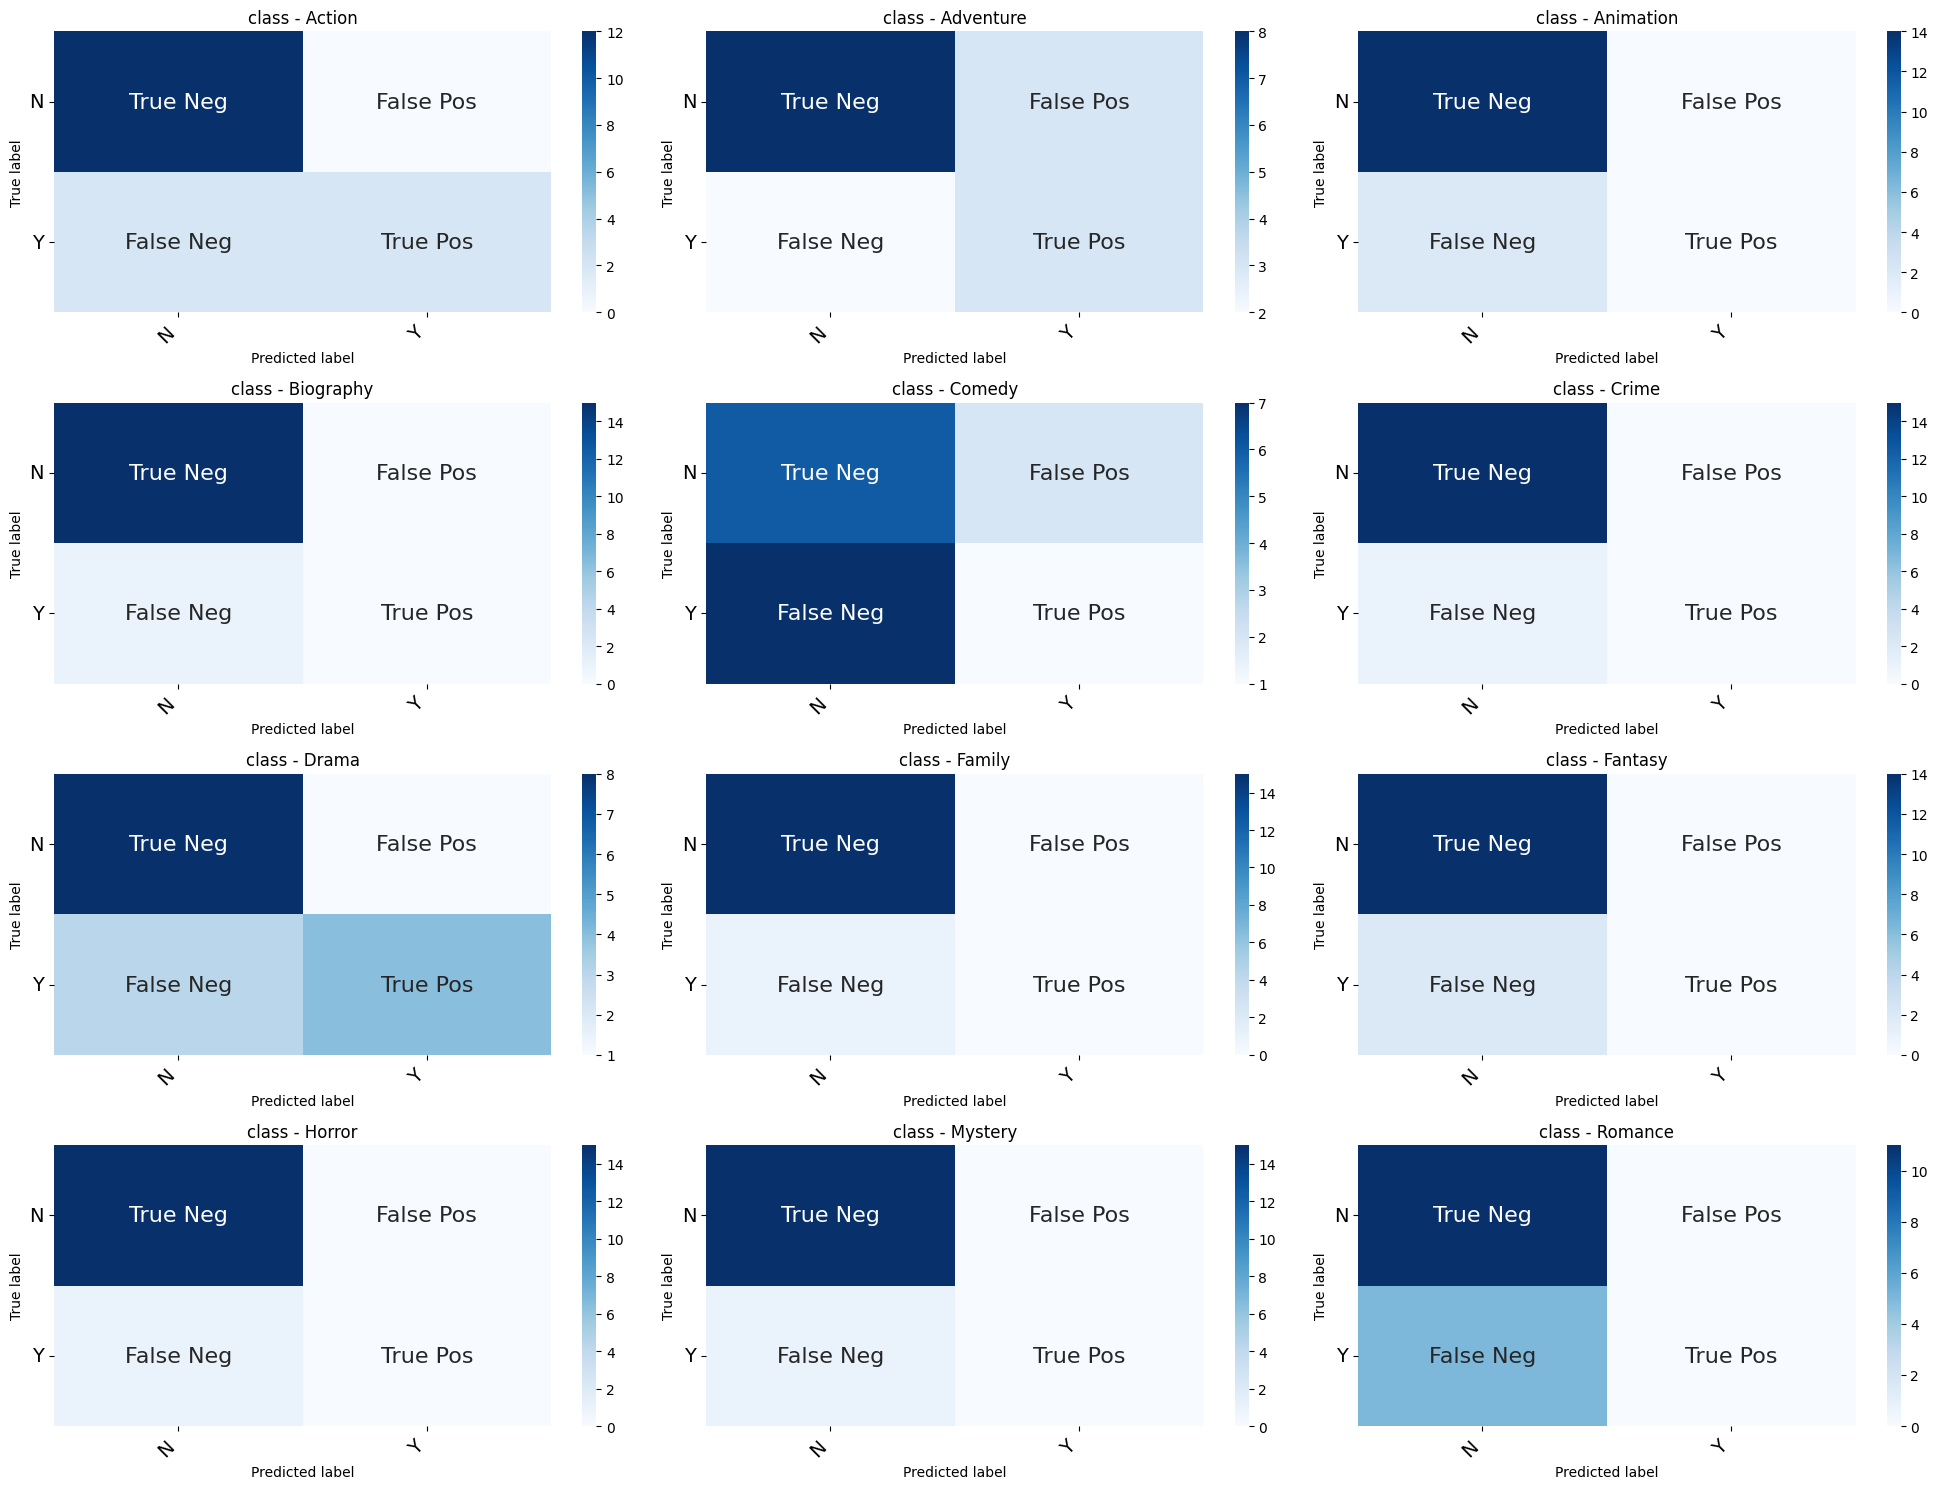

In [110]:
from sklearn.metrics import multilabel_confusion_matrix

matr = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
    
for axes, cfs_matrix, label in zip(ax.flatten(), matr, multilabel_binarizer.classes_):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()


In [112]:
import joblib

joblib.dump(grid_search, 'models/movie_model_pipeline.pkl')
joblib.dump(multilabel_binarizer, 'models/binarizer.pkl')

['models/binarizer.pkl']